# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

# Анализ результатов A/B-тестирования

- Автор: Макаров Александр Викторович
- Дата: 15.08.2025

## Цели и задачи проекта

**Цель:** Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.   

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Проверить дубликаты. Сравнить размеры групп, их статистики и распределение.
3. Провести статистический тест.
4. Сформулировать выводы по проведённому анализу.

## Описание данных

- Подготовленные данные находятся в таблице `yandex_knigi_data.csv` и содержат следующие поля:
- `city` — город пользователя;
- `puid` — идентификатор пользователя;
- `hours` — общее количество часов активности.

## Содержимое проекта

1. Загрузка данных и знакомство с ними.
2. Проверка дубликатов. Сравнение размеров групп, их статистик и распределения.
3. Статистический тест.
4. Итоговые выводы.

---

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')
df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
# Удалим лишний столбец Unnamed: 0
df = df.drop('Unnamed: 0', axis=1)
df.head(3)

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


Датафрейм содержит 3 столбца и 8784 строк. Пропусков нет, проверим дубликаты.

In [6]:
df.duplicated(subset='puid').sum()

244

In [7]:
df.groupby('puid').agg({'city': 'nunique'}).query('city > 1')

,city
puid,
2637041,2
9979490,2
10597984,2
10815097,2
13626259,2
...,...
1130000018516717,2
1130000018954257,2
1130000020425037,2


244 пользователя попали в обе группы, пересечений быль не должно, удалим эти строки.

In [8]:
user_groups = df.groupby('puid')['city'].nunique()
duplicate_users = user_groups[user_groups > 1].index
df_clean = df[~df['puid'].isin(duplicate_users)]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8296 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8296 non-null   object 
 1   puid    8296 non-null   int64  
 2   hours   8296 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 259.2+ KB


In [9]:
df_clean['puid'].nunique()

8296

Сравним размеры групп.

In [10]:
df_clean['city'].value_counts()

Москва             5990
Санкт-Петербург    2306
Name: city, dtype: int64

Пользователей из Москвы больше, чем из Санкт-Петербурга, более чем в два раза! Нам придётся учитывать этот фактор при выборе статистического теста. Проверим статистики.

In [11]:
df_clean.describe(percentiles=[0.25, 0.75, 0.95, 0.99])

,puid,hours
count,8.296000e+03,8296.000000
mean,8.990784e+12,10.963892
std,1.003939e+14,37.753906
min,9.668000e+03,0.000022
25%,3.251976e+08,0.057493
50%,8.894445e+08,0.884214
75%,1.523879e+09,5.944675
95%,1.953903e+09,55.625093
99%,2.048711e+09,153.656226
max,1.130000e+15,978.764775


Наблюдается большая разница между средним и медианой, похоже что данные имеют распределение далекое от нормального. Данные имеют довольно широкий разброс, на это указывает то что значение стандартного отклонения достаточно высокое (37.75) при среднем 10.96. Это подтверждает разница между минимальным и максимальнм значениями.

Проверим это и построим гистограмму распределения значений, а также диграмму размаха для столбца hours.

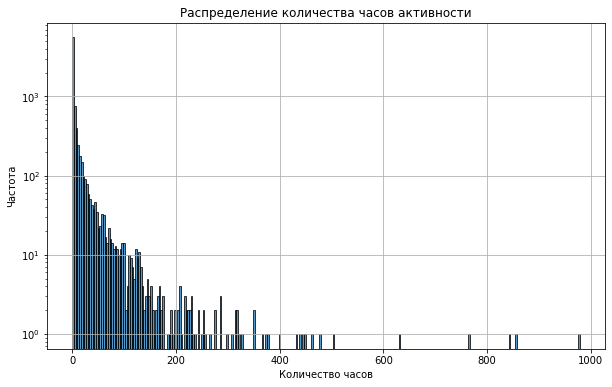

In [12]:
plt.figure(figsize=(10, 6))

# Строим гистограмму
df_clean['hours'].plot(
                kind='hist',
                bins=300, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
                log=True)

# Настраиваем оформление графика
plt.title('Распределение количества часов активности')
plt.xlabel('Количество часов')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

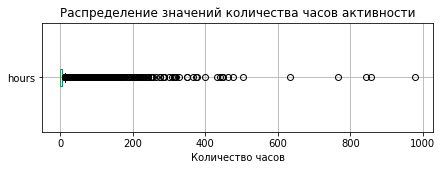

In [13]:
# Строим диаграмму размаха
df_clean.boxplot(column='hours', vert=False, figsize=(7, 2))

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества часов активности')
plt.xlabel('Количество часов')

# Выводим график
plt.show()

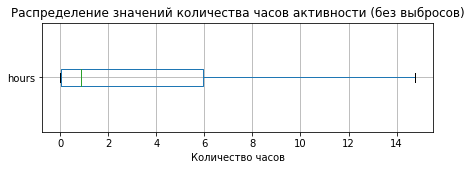

In [14]:
# То же самое без выбросов
df_clean.boxplot(column='hours', vert=False, showfliers=False, figsize=(7, 2))

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества часов активности (без выбросов)')
plt.xlabel('Количество часов')

# Выводим график
plt.show()

Центральные 50% значений («межквартильный размах») находятся в интервале между 0.05 и 6 часами, значения свыше 15 предлагается считать выбросами. 99% значений находятся в пределах 154 часов. Посмотрим на распределение значений в группах и в пределах этого интервала.

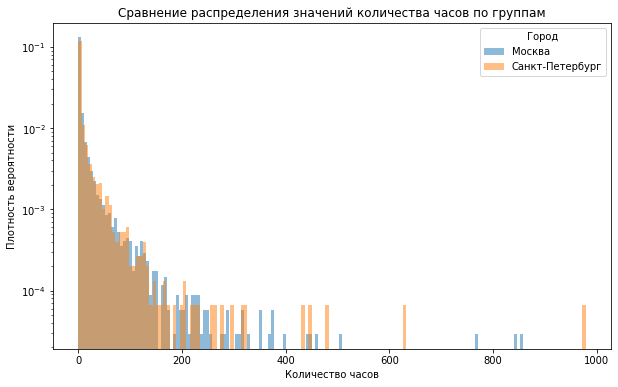

In [15]:
# Создаём фигуру графика
plt.figure(figsize=(10, 6))

# Строим гистограммы для каждого значения города
for i in df_clean['city'].unique():
    # Фильтруем данные по значению столбца 'city'
    df_clean.loc[df_clean['city'] == i, 'hours'].plot(
        kind='hist',
        density=True,
        bins=150,
        alpha=0.5,
        label=f'{i}',
        legend=True,
        log=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределения значений количества часов по группам')
plt.xlabel('Количество часов')
plt.ylabel('Плотность вероятности')
plt.legend(title='Город')
plt.show()

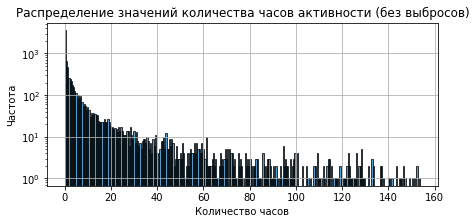

In [16]:
cleaned = df_clean[df_clean['hours'] <= df_clean['hours'].quantile(0.99)]['hours']

plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
cleaned.plot(
            kind='hist',
            bins=300,
            alpha=0.75,
            edgecolor='black',
            log=True
)

# Настраиваем оформление графика
plt.title('Распределение значений количества часов активности (без выбросов)')
plt.xlabel('Количество часов')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show() 

Распределение данных по группам примерно одинаковое: выбросы есть в обеих. Само распределение данных далеко от нормального, удалим выбросы.

In [17]:
emissions_clean = df_clean[df_clean['hours'] <= 160]
emissions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8215 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8215 non-null   object 
 1   puid    8215 non-null   int64  
 2   hours   8215 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 256.7+ KB


In [18]:
emissions_clean['city'].value_counts()

Москва             5930
Санкт-Петербург    2285
Name: city, dtype: int64

Были удалены дубликаты и выбросы. В связи с тем что распределение данных правоассиметрично с тяжелым хвостом и группы сильно различаются по размерам, будем применять тест Уэлча.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [19]:
metric_a = emissions_clean[emissions_clean.city=='Москва']['hours'] # выборка целевой метрики для группы A
metric_b = emissions_clean[emissions_clean.city=='Санкт-Петербург']['hours'] # выборка целевой метрики для группы B

alpha = 0.05 # устанавливаем уровень значимости

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_b,
    metric_a, 
    equal_var=False,
    alternative='greater' # поскольку альтернативная гипотеза о том, что выборочное среднее второй выборки (metric_b) больше первой
) 
# применяем t-тест Уэлча
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B не различаются')
    print('Интерпретация: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.')

p-value теста Уэлча = 0.24
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B не различаются
Интерпретация: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


Проведем тест Уэлча на данных с выбросами.

In [20]:
metric_a = df_clean[df_clean.city=='Москва']['hours'] # выборка целевой метрики для группы A
metric_b = df_clean[df_clean.city=='Санкт-Петербург']['hours'] # выборка целевой метрики для группы B

alpha = 0.05 # устанавливаем уровень значимости

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_b,
    metric_a,
    equal_var=False,
    alternative='greater' # поскольку альтернативная гипотеза о том, что выборочное среднее второй выборки (metric_b) больше первой
) 
## применяем t-тест Уэлча
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B не различаются')
    print('Интерпретация: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.')

p-value теста Уэлча = 0.33
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B не различаются
Интерпретация: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


Хотя значения p-value отличаются, результаты обоих тестов совпадают, нулевая гипотеза подтверждается.

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



В тестировании участвовали группы, размеры которых отличались более чем в 2 раза.
В Москве до удаления выбросов было 5990, после удаления стало 5930.
В Санкт-Петербурге было 2306, после удаления стало 2285.
Распределение значений- правоассеметричное с тяжелым хвостом.
Использовался тест Уэлча, уровень значимости составил 0.05.


По результатам тестирования было получено p_value = 0.24 (для теста без выбросов) и p_value= 0.33 (для теста с выбросами).
В обоих тестах p_value выше уровня значимости, что говорит о подтверждении нулевой гипотезы: Жители Москвы и Санкт-Петербурга проводят за чтением и прослушиванием книг, одинаковое количество времени.

Полученный результат можно объяснить схожестью менталитета и привычек жиетелй двух столиц.


# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Цель проекта - проверить гипотезу о том, что внедрение новой версии сайта (упрощение интерфейса) приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

Задачи:

    1. загрузить данные тестирования.
    2. проверить корректность проведения теста.
    3. анализ полученных результатов.

## 2. Загрузите данные, оцените их целостность.


In [21]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [22]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Судя по выведенным данным, в таблице присутствуют данные другого теста- recommender_system_test.

In [23]:
participants['ab_test'].value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

In [24]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Пропусков нет. Проверим дубликаты.

In [25]:
participants.duplicated(subset=['user_id']).sum()

887

In [26]:
participants.groupby('user_id').agg({'group': 'nunique'}).query('group > 1')

,group
user_id,
001064FEAAB631A1,2
00341D8401F0F665,2
00EFA157F7B6E1C4,2
01B9975CAE144B78,2
020A95B66F363AFB,2
...,...
FC37CBE8211E02A8,2
FCF70F6E1871BD78,2
FE82D7FC50D4155B,2


Оказалось что 446 пользователей попали в две тестовые группы.

In [27]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [28]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Таблица `ab_test_events` содержит 787286 строк. Пропуски есть в столбце `details` в количестве 538264 (68%).

In [29]:
events['details'].isna().sum()

538264

In [30]:
events['details'].isna().sum() / len(events['details']) * 100

68.3695632844989

In [31]:
events.duplicated().sum()

36318

Таблица ab_test_events сожержит 787286 строк,  в столбце details присутствует 538264 (68,37%) пропусков. Также в таблице присутствуют 36318 дупликатов.

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

В задании говорилось об 1 тесте, но в предоставленных данных, пристутствуют данные 2х тестов. Проверим пересечения в тестах.

In [32]:
group_a = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'A')]['user_id']
group_b = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B')]['user_id']
list(set(group_a) & set(group_b))

[]

Пересечений в нашем тесте нет. Проверим пересечения с другим тестом.

In [33]:
user_test_counts = participants.groupby('user_id')['ab_test'].nunique()

# Выберем только тех, кто участвовал более чем в одном тесте
overlapping_users = user_test_counts[user_test_counts > 1].index

# Получим все строки с этими пользователями
df_overlap = participants[participants['user_id'].isin(overlapping_users)]
df_overlap

,user_id,group,ab_test,device
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
9,00341D8401F0F665,A,recommender_system_test,iPhone
10,00341D8401F0F665,B,interface_eu_test,iPhone
25,0082295A41A867B5,A,interface_eu_test,iPhone
...,...,...,...,...
14490,FF2174A1AA0EAD20,A,recommender_system_test,Android
14495,FF44696E39039D29,B,interface_eu_test,Mac
14496,FF44696E39039D29,A,recommender_system_test,Mac
14522,FFF28D02B1EACBE1,B,recommender_system_test,PC


Т.к. поведение пользователя в одном тесте могло повлиять на его поведение в другом тесте, для частоты эксперемента лучше удалить строки с пользователями участвовавшими в обоих тестах.

In [34]:
participants_clean = participants[~participants['user_id'].isin(overlapping_users)]
participants_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12751 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  12751 non-null  object
 1   group    12751 non-null  object
 2   ab_test  12751 non-null  object
 3   device   12751 non-null  object
dtypes: object(4)
memory usage: 498.1+ KB


Отфильтруем только участников нашего теста.

In [35]:
test = participants_clean[participants_clean['ab_test'] == 'interface_eu_test']
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9963 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  9963 non-null   object
 1   group    9963 non-null   object
 2   ab_test  9963 non-null   object
 3   device   9963 non-null   object
dtypes: object(4)
memory usage: 389.2+ KB


Посчитаем размер групп.

In [36]:
a2 = test[test['group'] == 'A']['user_id'].shape[0]
b2 = test[test['group'] == 'B']['user_id'].shape[0]
a2, b2

(4952, 5011)

In [37]:
round(100 * (b2 - a2) / b2, 1)

1.2

Группы распределены практически равномерно. Посмотрим доли различных устройств в группах.

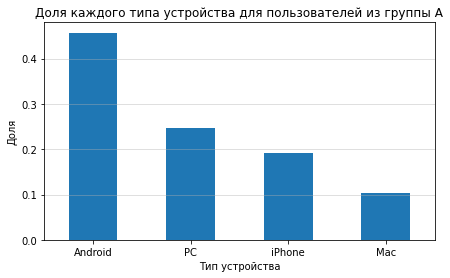

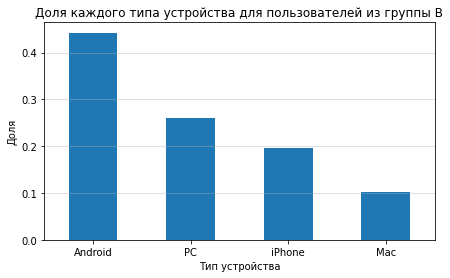

In [38]:
# Построим диаграмму для группы А
plt.figure(figsize=(7, 4))

test[test['group'] == 'A']['device'].value_counts(normalize=True).plot(
               kind='bar',
               rot=0,
               legend=False,
                title='Доля каждого типа устройства для пользователей из группы A')
# Настраиваем оформление графика
plt.ylabel('Доля')
plt.xlabel('Тип устройства')
# Добавляем сетку графика для удобства
plt.grid(axis='y', alpha=0.5)

# Построим диаграмму для группы B
plt.figure(figsize=(7, 4))

test[test['group'] == 'B']['device'].value_counts(normalize=True).plot(
               kind='bar',
               rot=0,
               legend=False,
                title='Доля каждого типа устройства для пользователей из группы B')
# Настраиваем оформление графика
plt.ylabel('Доля')
plt.xlabel('Тип устройства')
# Добавляем сетку графика для удобства
plt.grid(axis='y', alpha=0.5)
# Выводим график
plt.show()

Распределение устройств в группах также практически равномерно.

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями;

In [39]:
# отфильтруем события участников нашего теста
events_filtered = events[events['user_id'].isin(test['user_id'])]
events_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73815 entries, 64672 to 780371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     73815 non-null  object        
 1   event_dt    73815 non-null  datetime64[ns]
 2   event_name  73815 non-null  object        
 3   details     19450 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


In [40]:
events_filtered['details'].isna().sum()

54365

In [41]:
events_filtered['details'].isna().sum() / len(events_filtered['details']) * 100

73.6503420713947

In [42]:
events_filtered.duplicated().sum()

5741

Датафрейм с собитиями участников нужного нам теста содержит 73815 строк. В столбце details присутствует 54365 (73,65%) пропусков. Также в 5741 строке присутсвуют дупликаты, удалим их.

In [43]:
events_filtered.duplicated().sum()

5741

Дубликаты присутствуют в количестве 5741 строка. Удалим дубликаты.

In [44]:
events_filtered = events_filtered.drop_duplicates()
events_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68074 entries, 64672 to 780371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     68074 non-null  object        
 1   event_dt    68074 non-null  datetime64[ns]
 2   event_name  68074 non-null  object        
 3   details     18864 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.6+ MB


- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [45]:
# Найдём дату регистрации (первое событие каждого пользователя)
registration_date = events_filtered.groupby('user_id')['event_dt'].min().reset_index()
registration_date.rename(columns={'event_dt': 'registration_date'}, inplace=True)

# Присоединим дату регистрации к каждому событию
events_filtered = events_filtered.merge(registration_date, on='user_id', how='left')

# Посчитаем разницу
events_filtered['days_since_registration'] = (events_filtered['event_dt'] - events_filtered['registration_date']).dt.days

# Оставим только события из первых 7 дней
events_7days = events_filtered[events_filtered['days_since_registration'] < 7]
events_7days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58692 entries, 0 to 68052
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  58692 non-null  object        
 1   event_dt                 58692 non-null  datetime64[ns]
 2   event_name               58692 non-null  object        
 3   details                  15800 non-null  object        
 4   registration_date        58692 non-null  datetime64[ns]
 5   days_since_registration  58692 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 3.1+ MB


Для проверки фильтрации выведем события пользователя с наибольшим количеством событий.

In [46]:
events_7days['user_id'].value_counts().idxmax()

'30A2D030A6CB121A'

In [47]:
events_7days[events_7days['user_id'] == '7B43E032FA958B3D']

,user_id,event_dt,event_name,details,registration_date,days_since_registration
44944,7B43E032FA958B3D,2020-12-20 23:59:41,registration,-0.43,2020-12-20 23:59:41,0
45054,7B43E032FA958B3D,2020-12-21 00:36:07,login,NaN,2020-12-20 23:59:41,0
45064,7B43E032FA958B3D,2020-12-21 00:37:12,login,NaN,2020-12-20 23:59:41,0
45073,7B43E032FA958B3D,2020-12-21 00:39:01,login,NaN,2020-12-20 23:59:41,0
45074,7B43E032FA958B3D,2020-12-21 00:39:03,login,NaN,2020-12-20 23:59:41,0
52827,7B43E032FA958B3D,2020-12-22 11:54:16,login,NaN,2020-12-20 23:59:41,1
52828,7B43E032FA958B3D,2020-12-22 11:54:17,product_page,NaN,2020-12-20 23:59:41,1
52829,7B43E032FA958B3D,2020-12-22 11:54:18,product_page,NaN,2020-12-20 23:59:41,1
56285,7B43E032FA958B3D,2020-12-23 06:32:40,product_page,NaN,2020-12-20 23:59:41,2
56286,7B43E032FA958B3D,2020-12-23 06:32:41,product_page,NaN,2020-12-20 23:59:41,2


Фильтрация проведена корректно, в датафреме остались события не старше 7 дней с момента регистрации.

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [48]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень конверсии
mde = 0.03  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


Размер групп у нас 4952 и 5011, что выше необходимого минимума 3761.

- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [49]:
# Объединяем события с группами
df_merged = events_7days.merge(test, on='user_id', how='left')

# Фильтруем только события типа "purchase"
df_purchases = df_merged[df_merged['event_name'] == 'purchase']

# Считаем уникальных покупателей в каждой группе
purchases_by_group = df_purchases.groupby('group')['user_id'].nunique().reset_index()
purchases_by_group.rename(columns={'user_id': 'buyers'}, inplace=True)

# Считаем общее количество участников в каждой группе
total_by_group = test.groupby('group')['user_id'].nunique().reset_index()
total_by_group.rename(columns={'user_id': 'total_users'}, inplace=True)

# Объединяем всё
result = total_by_group.merge(purchases_by_group, on='group', how='left')
result['buyers'] = result['buyers'].fillna(0).astype(int)

# Добавим конверсию
result['conversion_rate'] = round(result['buyers'] / result['total_users'], 4)
result

,group,total_users,buyers,conversion_rate
0,A,4952,1377,0.2781
1,B,5011,1480,0.2954


- сделаем предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Активность покупателей в тестовой группе стала больше чем в контрольной группе, CR 0.2954 против 0.2781 соответственно.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

- Нулевая гипотеза H₀: Конверсия в двух группах не различается.

- Альтернативная гипотеза H₁: Конверсия в тестовой группе выше, и это различие статистически значимо.

In [50]:
# Посчитаем размеры групп A и В
n_a = test[test['group'] == 'A']['user_id'].nunique()
n_b = test[test['group'] == 'B']['user_id'].nunique()

# Посчитаем кол-во покупателей в группах A и В
m_a = df_purchases[df_purchases['group'] == 'A']['user_id'].nunique()
m_b = df_purchases[df_purchases['group'] == 'B']['user_id'].nunique()

# Посчитаем конверсию для каждой группы: A и B
p_a, p_b = m_a/n_a, m_b/n_b

# Проверим предпосылку о достаточном количестве данных
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

# Установим уровень значимости
alpha = 0.05

# Проведем Z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

# Выведем полученное p-value
print(f'pvalue={p_value_ztest}') 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.028262547212292124
Нулевая гипотеза не находит подтверждения!


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

В тесте принимали участие группы пользователей. Размер групп сопоставим (в контрольной -4952, в тестовой -5011).
- p-value составил 0.028
Т.к. уровень значимости 0.5, нулевая гипотеза не подтвердилась, конверсия в тестовой группе выше и различие статистически значимо.
Но разница конверсии в группах (контрольная 0.2781 и тестовая 0.2954) составляет 1.73% что меньше ожидаемых 3% 